# Exploratory analysis of seasonal timeseries

In [12]:
source('../NMEG_utils/r_functions/load_nmeg.r')
library(ggplot2)

mpj <- daily_to_xts(get_daily_file('Mpj', 'aflx', make_new=FALSE))
mpj_s <- daily_to_xts(get_daily_file('Mpj', 'soilmet', make_new=FALSE))

names(mpj)

[1] "GPP_g_int"      "RECO_g_int"     "FC_F_g_int"     "ET_mm_24hint_0"
 [5] "P_F_sum"        "TA_F_avg"       "RH_F_avg"       "SW_IN_F_avg"   
 [9] "RNET_F_avg"     "VPD_F_avg"      "TA_F_min"       "VPD_F_min"     
[13] "TA_F_max"       "VPD_F_max"      "ET_mm_dayint"   "PET_mm_dayint"

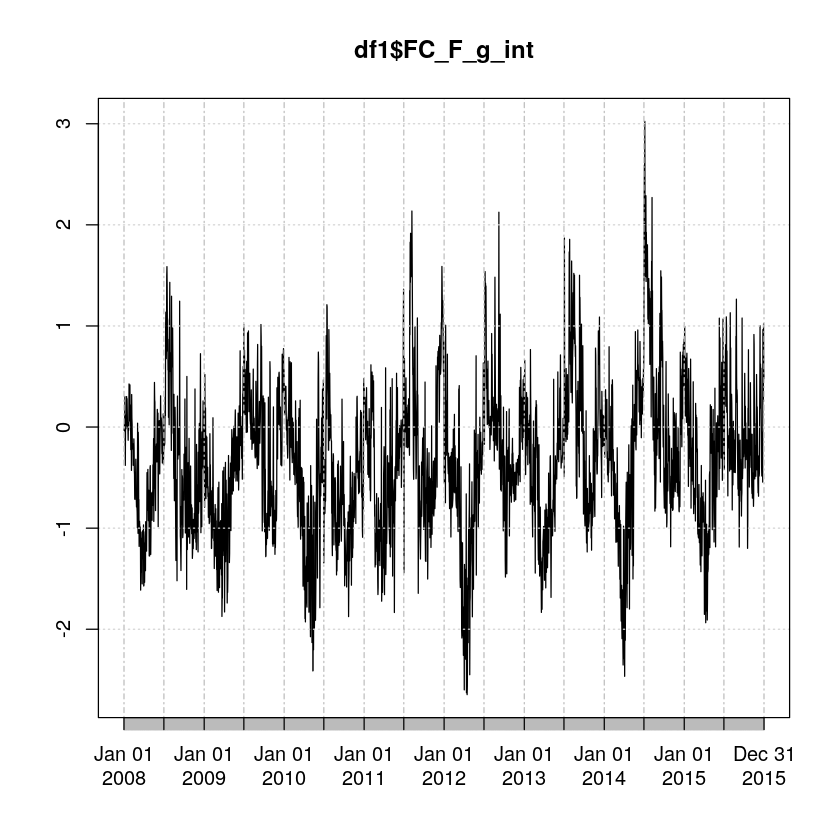

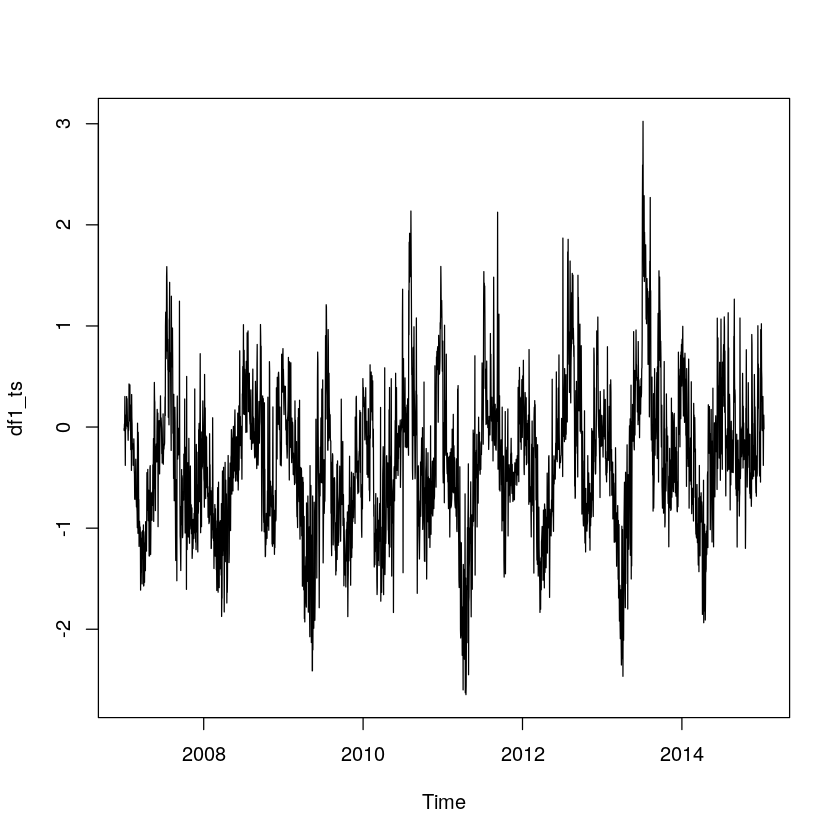

In [13]:
df1 <- mpj
# Different time series objects have different plotting methods (but "plot(...)" should work for any):
# 1. Plot the xts
plot.xts(df1$FC_F_g_int)
# 2. Convert to a ts object and plot
df1_ts<-ts(df1$FC_F_g_int, frequency = 365, start = c(2007, 1, 1),end = c(2015, 12, 31))
plot.ts(df1_ts)
# or in ggplot2
#ggplot(df1, aes(x=Index, y=FC_F_g_int)) + geom_line()

## Decomposition methods

### Simple moving average

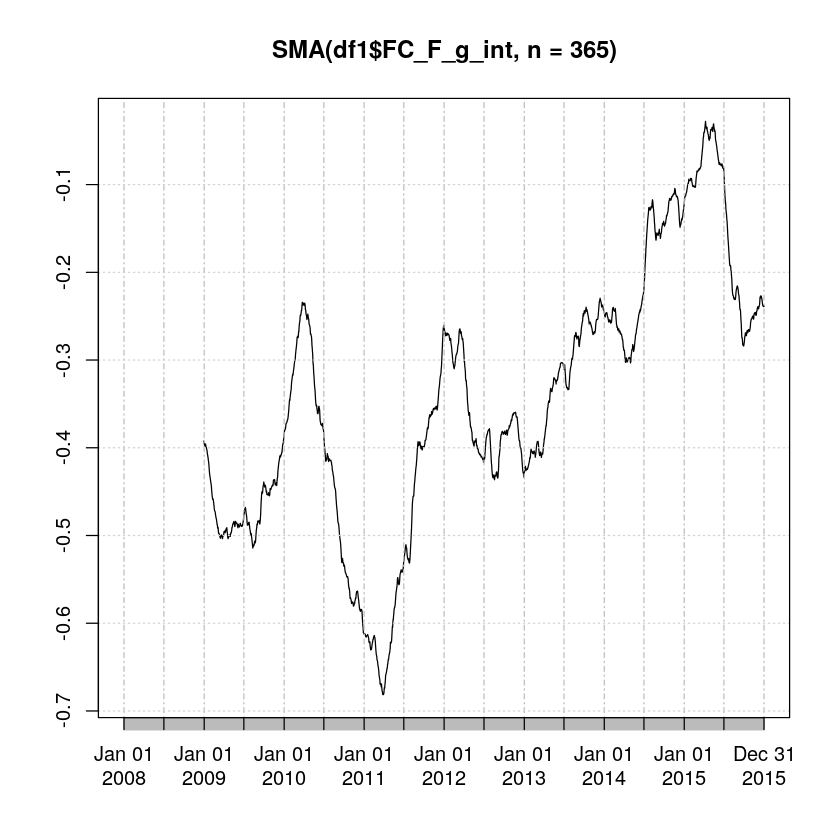

In [4]:
# Plot 1 year moving average with SMA
library("TTR")
plot(SMA(df1$FC_F_g_int,n=365))

### Full additive decomposition

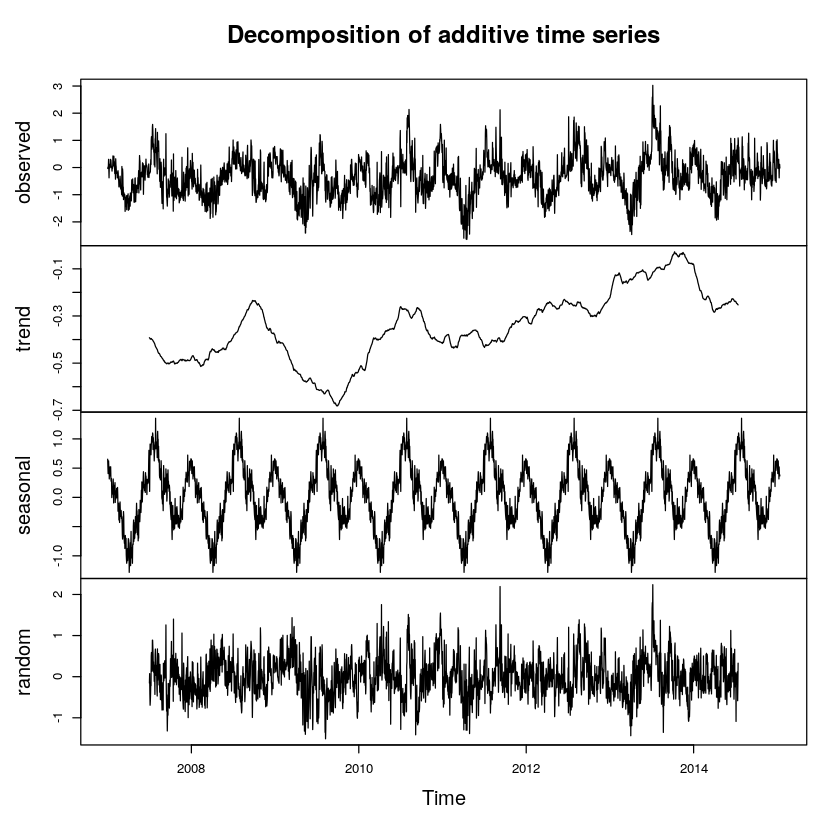

Loading required package: timeDate
This is forecast 6.2 



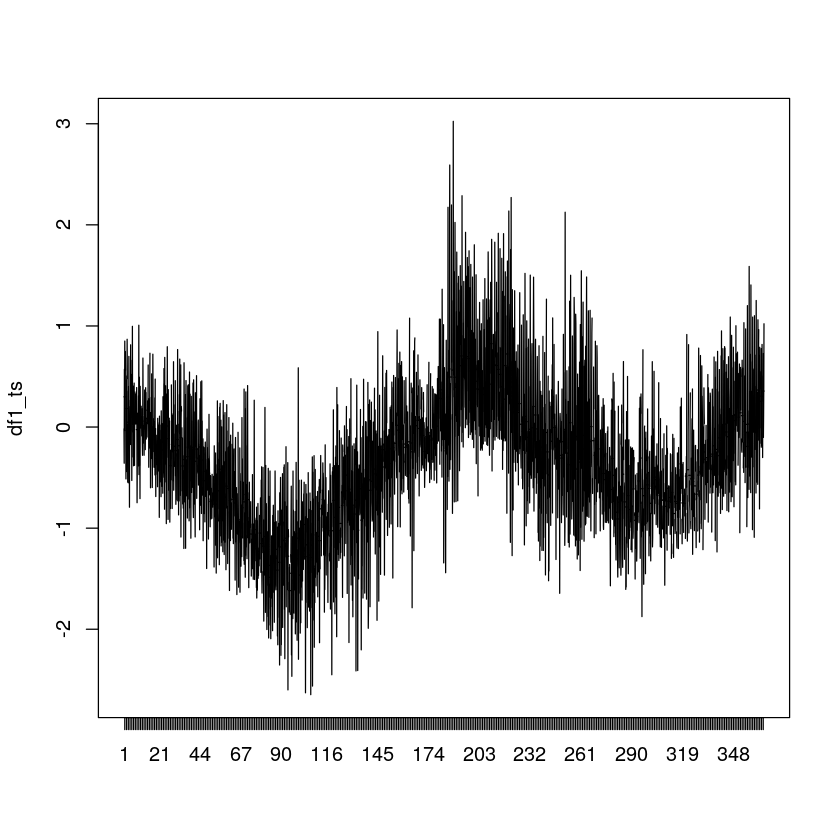

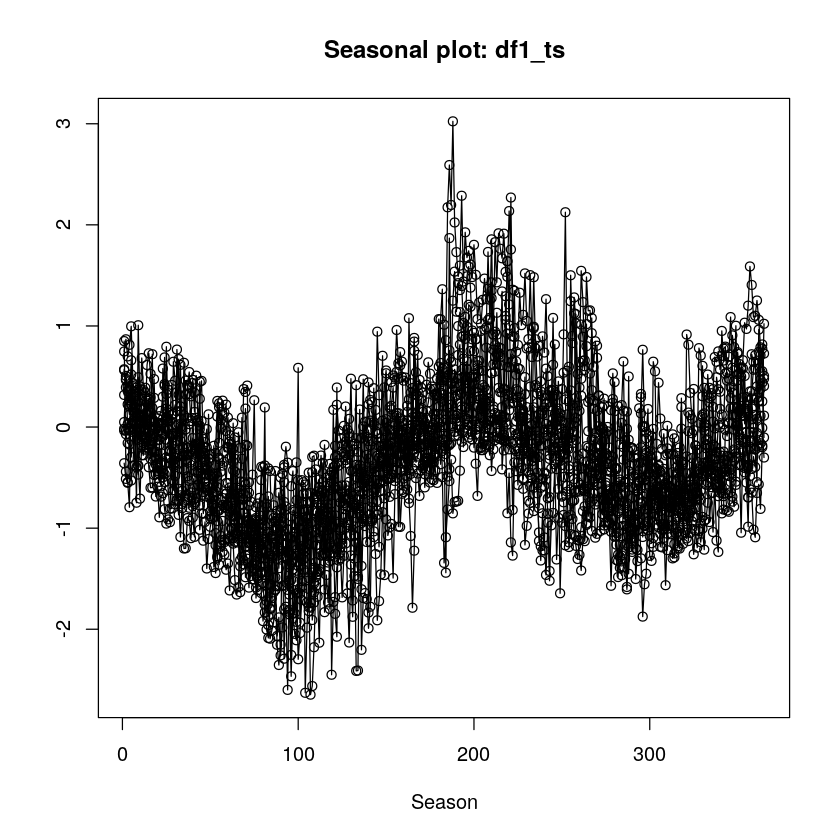

In [5]:
# Decomposition methods for seasonality
attr(df1, 'frequency') <- 365
# decompose only seems to work for ts objects
df1_decomp <- decompose(df1_ts)
plot(df1_decomp)
# Make some seasonal plots
monthplot(df1_ts)
# one from forecast
library(forecast)
seasonplot(df1_ts) 

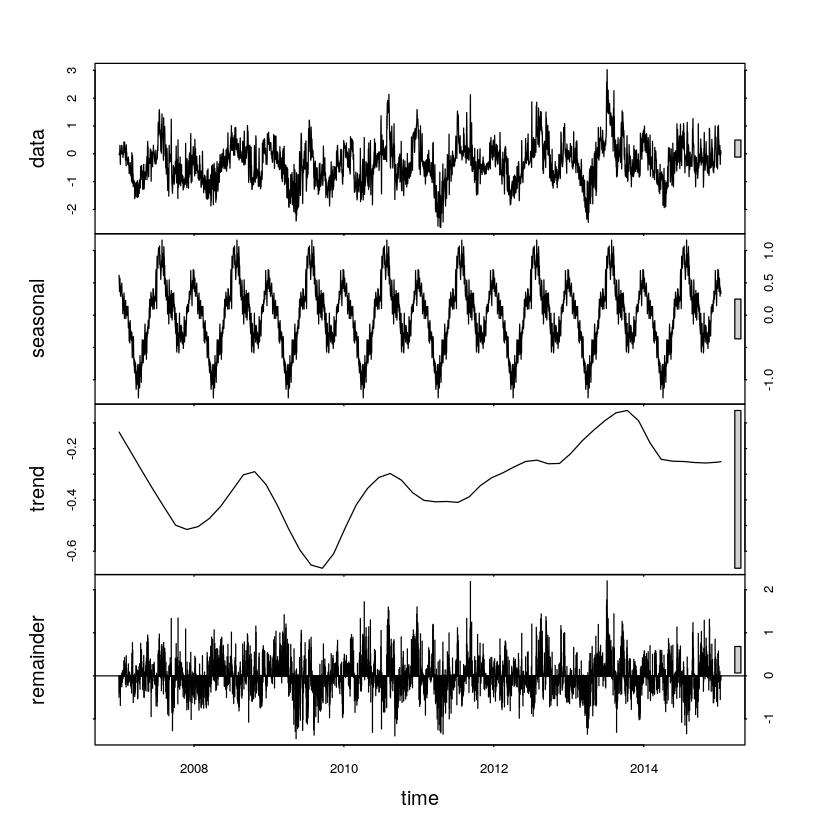

In [6]:
# Seasonal decomposition using loess
df1_decomp2 <- stl(df1_ts, s.window="period", na.action=na.omit)
plot(df1_decomp2)

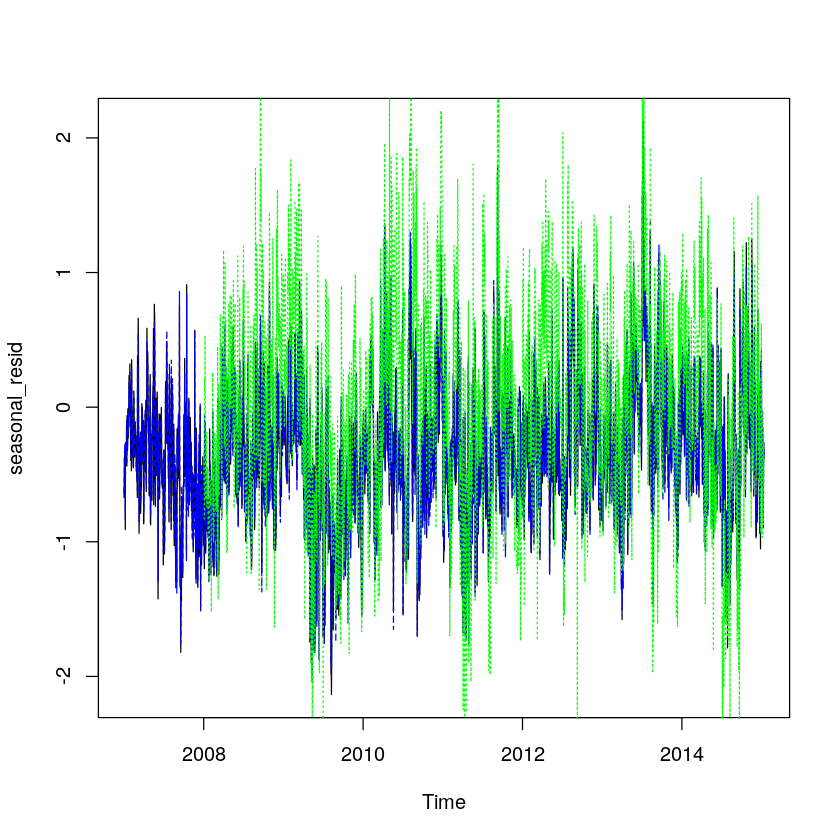

In [16]:
# Plot the seasonal residual (data - seasonal trend)
seasonal_resid <- df1_ts - df1_decomp$seasonal
seasonal_resid2 <- df1_ts - df1_decomp2$time.series[,'seasonal']
# an alternative way to adjust for seasonal differences
seasonal_resid3 <- diff(df1_ts, 365)


plot(seasonal_resid)
lines(seasonal_resid2, col='blue', lty='dashed')
lines(seasonal_resid3, col='green', lty='dotted')

## Autocorrelation and stationarity of time series

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations.

We have already removed the seasonal component in seasonal_resid timeseries. Remaining non-stationarity might be overcome with differencing.

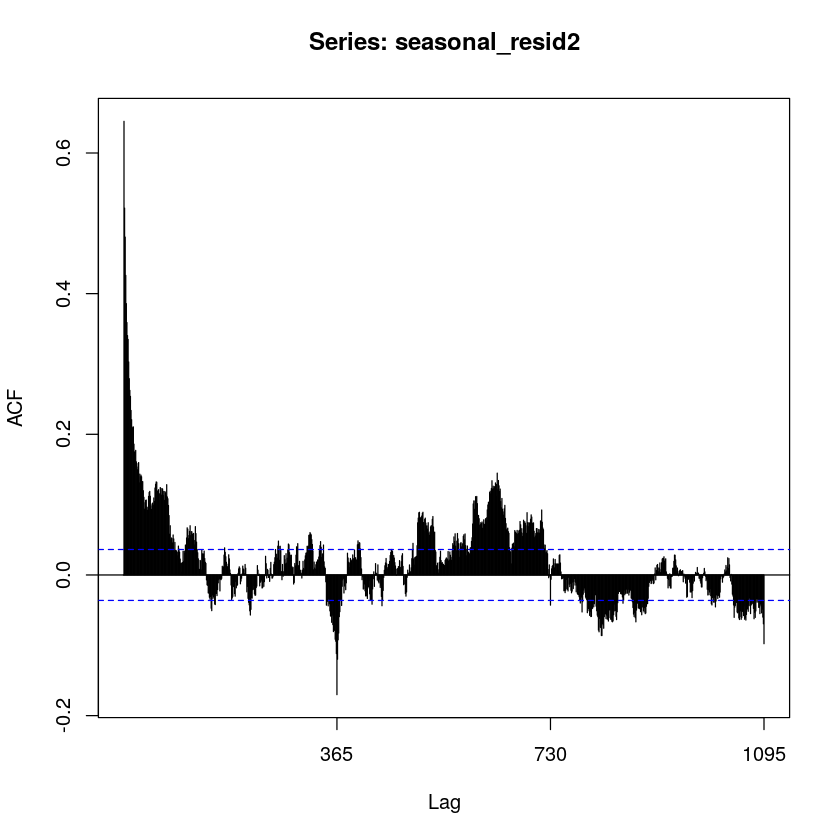

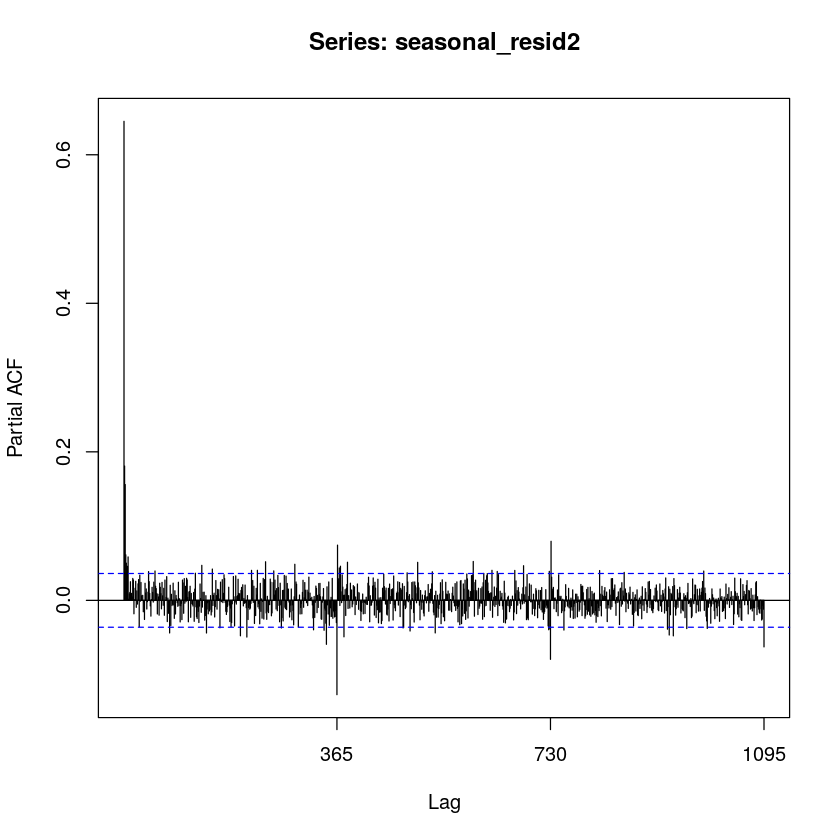

In [15]:
Acf(seasonal_resid2,lag.max=3*365)
Pacf(seasonal_resid2,lag.max=3*365)

# Acf functions indicates significant autocorrelation

In [17]:
# 1) Test for stationarity
# Augemented Dickey-Fuller Test
# A significant p-value means that no unit root is present (no need for differencing)
# Rejecting the null hypothesis suggests that a time series as stationary (from the tseries package)
library(tseries)
adf.test(df1_ts)

# Estimate number of diffs needed to make stationary
ndiffs(df1_ts)
nsdiffs(df1_ts)

Warning message:
In adf.test(df1_ts): p-value smaller than printed p-value


	Augmented Dickey-Fuller Test

data:  df1_ts
Dickey-Fuller = -6.1245, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary


[1] 1

[1] 0

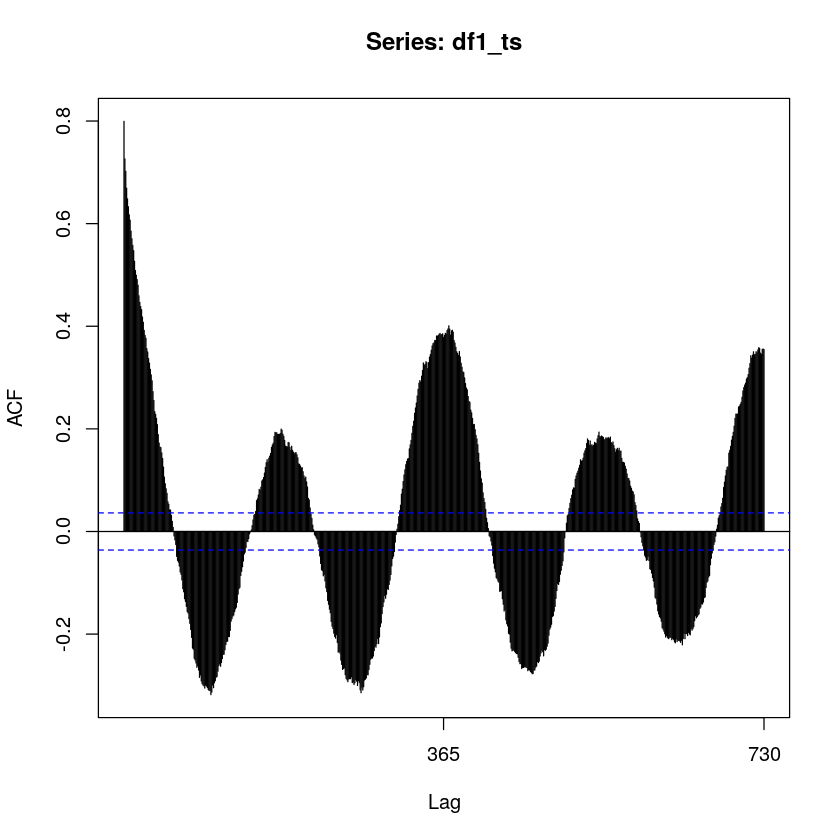

In [18]:
Acf(df1_ts,lag.max=2*365)
#Acf(df1_ts,lag.max=2*365,plot=FALSE) # this prints out the autocorrelation values


Call:
arima(x = df1_ts, order = c(0, 0, 0), seasonal = list(order = c(0, 1, 0), period = 365))


sigma^2 estimated as 0.6216:  log likelihood = -2169.84,  aic = 4341.68

Training set error measures:
                     ME      RMSE       MAE      MPE     MAPE     MASE
Training set 0.02420953 0.7200977 0.5170202 3.610055 428.9583 1.614506
                  ACF1
Training set 0.6640237


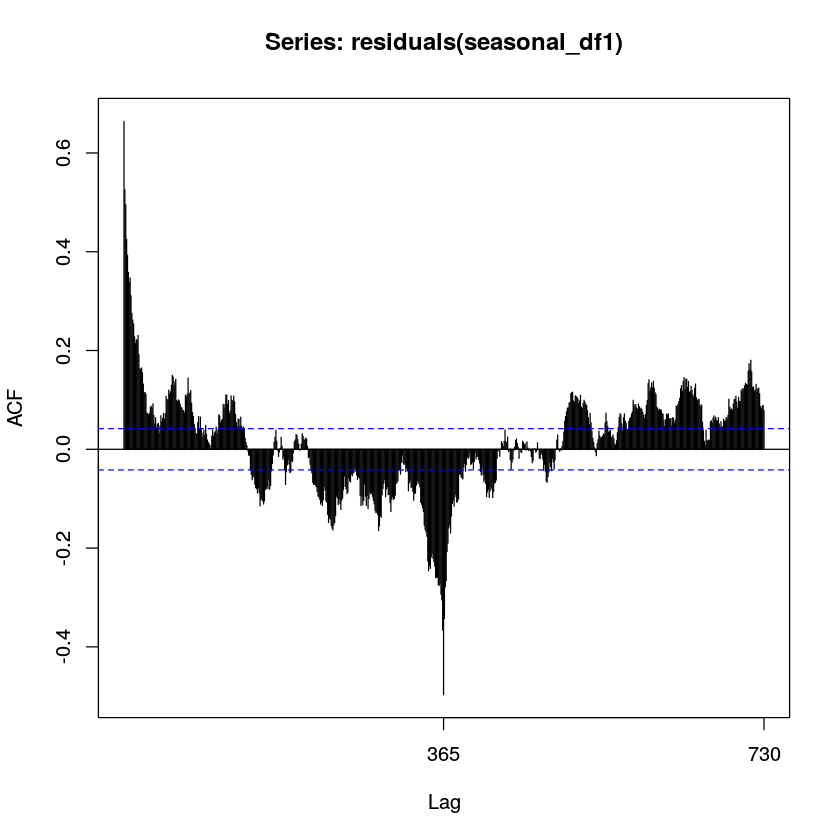

In [12]:
seasonal_df1<-arima(df1_ts,order=c(0,0,0),
                   seasonal=list(order=c(0,1,0),period=365))
res_df1<-(residuals(seasonal_df1))
Acf(residuals(seasonal_df1))
summary(seasonal_df1)